# Language Detection on the Edge

## Imports

In [10]:
# Imports
import wave
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, AvgPool1D, MaxPool1D, ZeroPadding1D, BatchNormalization, Flatten, Dense, Activation, GlobalAveragePooling1D
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

## Pre-process Data

In [11]:
def load_data_generator(dataset_dir: str, file_names: list):

    NUM_CLASSES = len(file_names)
    
    x_train, x_test, x_val, y_train, y_test, y_val = [], [], [], [], [], []
    
    for enum, file in enumerate(file_names):
        path = dataset_dir + file + '.pkl'
        with open(path, 'rb') as data_file:
            data = pickle.load(data_file)

            data_train = data['data_train']
            data_test = data['data_test']
            data_val = data['data_val']

        sample_rate=16000

        x_train_inter = []
        for i in data_train:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_train_inter.extend(np.split(array_intermediate, num_sec))
        
        
        x_test_inter = []
        for i in data_test:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_test_inter.extend(np.split(array_intermediate, num_sec))

        x_val_inter = []
        for i in data_val:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_val_inter.extend(np.split(array_intermediate, num_sec))

        y_train_inter = [[enum]]*len(x_train_inter)
        y_test_inter = [[enum]]*len(x_test_inter)
        y_val_inter = [[enum]]*len(x_val_inter)

        x_train.extend(x_train_inter)
        x_test.extend(x_test_inter)
        x_val.extend(x_val_inter)

        y_train.extend(y_train_inter)
        y_test.extend(y_test_inter)
        y_val.extend(y_val_inter)
        

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_val = np.array(x_val)

    y_train = to_categorical(np.array(y_train), num_classes = NUM_CLASSES)
    y_test = to_categorical(np.array(y_test), num_classes = NUM_CLASSES)
    y_val = to_categorical(np.array(y_val), num_classes = NUM_CLASSES)

    return x_train, x_test, x_val, y_train, y_test, y_val

In [12]:
dataset_dir = '../data/pre-train/raw/'
# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.fr_fr', 'fleurs.it_it']
CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr']




x_train, x_test, x_val, y_train, y_test, y_val = load_data_generator(dataset_dir, CLASSES)

print('----------------------------------------------------------------------')
print(f'Number of samples in train: {len(x_train)}')
print(f'Number of samples in test: {len(x_test)}')
print(f'Number of samplesin validation: {len(x_val)}')
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')
print(f'x_train shape: {x_train.shape} | y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} | y_test shape: {y_test.shape}')
print(f'x_val shape: {x_val.shape} | y_val shape: {y_val.shape}')
print('----------------------------------------------------------------------')

----------------------------------------------------------------------
Number of samples in train: 122593
Number of samples in test: 34354
Number of samplesin validation: 15336
----------------------------------------------------------------------
----------------------------------------------------------------------
x_train shape: (122593, 16000) | y_train shape: (122593, 4)
x_test shape: (34354, 16000) | y_test shape: (34354, 4)
x_val shape: (15336, 16000) | y_val shape: (15336, 4)
----------------------------------------------------------------------


In [16]:
# with open(f'../data/pre-train/x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# f.close()

# with open(f'../data/pre-train/x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)
# f.close()

# with open(f'../data/pre-train/x_val.pkl', 'wb') as f:
#     pickle.dump(x_val, f)
# f.close()

# with open(f'../data/pre-train/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# f.close()

# with open(f'../data/pre-train/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
# f.close()

# with open(f'../data/pre-train/y_val.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# f.close()

## Analysis of Training Data

--------------------------------COUNT EN---------------------------------
Train	 EN: 25689
Test	 EN: 6055
Val	 EN: 3578
--------------------------------COUNT DE---------------------------------
Train	 DE: 30976
Test	 DE: 10926
Val	 DE: 4371
--------------------------------COUNT ES---------------------------------
Train	 ES: 30326
Test	 ES: 10693
Val	 ES: 4670
--------------------------------COUNT FR---------------------------------
Train	 FR: 35602
Test	 FR: 6680
Val	 FR: 2717
-------------------------------------------------------------------------
--------------------------------MINIMUM COUNTS---------------------------------
Min count train: 25689
Min count test: 6055
Min count val: 2717
-------------------------------------------------------------------------


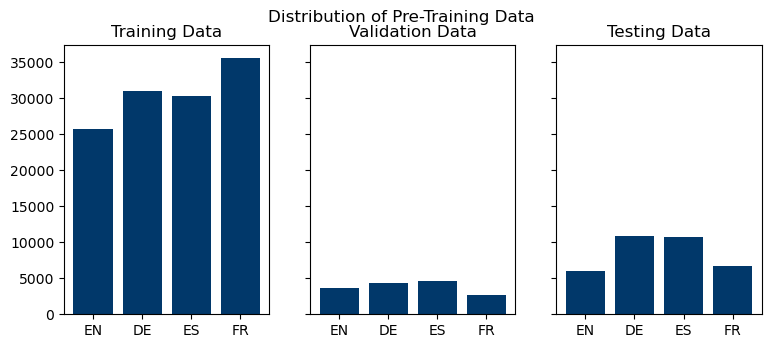

In [4]:

labels_train = [np.argmax(i) for i in y_train]
labels_test = [np.argmax(i) for i in y_test]
labels_val = [np.argmax(i) for i in y_val]

unique_train, counts_train = np.unique(labels_train, return_counts=True)
unique_test, counts_test = np.unique(labels_test, return_counts=True)
unique_val, counts_val = np.unique(labels_val, return_counts=True)

del labels_train
del labels_test
del labels_val

# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']
LABELS = ['EN', 'DE', 'ES', 'FR']




fig, axes = plt.subplots(1,3, figsize=(9, 3.5), sharey=True, edgecolor='black')
axes[0].bar(LABELS, counts_train, color='#01386a')
axes[0].set_title('Training Data')

axes[1].bar(LABELS, counts_val, color='#01386a')
axes[1].set_title('Validation Data')

axes[2].bar(LABELS, counts_test, color='#01386a')
axes[2].set_title('Testing Data')

fig.suptitle('Distribution of Pre-Training Data')


for enum, i in enumerate(counts_train):
    print(f'--------------------------------COUNT {LABELS[enum]}---------------------------------')
    print(f'Train\t {LABELS[enum]}: {i}')
    print(f'Test\t {LABELS[enum]}: {counts_test[enum]}')
    print(f'Val\t {LABELS[enum]}: {counts_val[enum]}')
print('-------------------------------------------------------------------------')

print('--------------------------------MINIMUM COUNTS---------------------------------')
print(f'Min count train: {min(counts_train)}')
print(f'Min count test: {min(counts_test)}')
print(f'Min count val: {min(counts_val)}')
print('-------------------------------------------------------------------------')

## Preparing Data for Training

In [5]:
# Fixed point conversion
FIXED_POINT = 9
x_train /= 2**FIXED_POINT
x_test  /= 2**FIXED_POINT

In [6]:
# perms = np.random.permutation(len(y_test))[0:250]
# x_test_250 = x_test[perms]
# y_test_250 = y_test[perms]
# np.savetxt('x_test_gsc_250.csv', x_test_250.reshape((x_test_250.shape[0], -1)), delimiter=',', fmt='%s')
# np.savetxt('y_test_gsc_250.csv', y_test_250, delimiter=',', fmt='%s')

## Build model

In [7]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Building the model

model = Sequential()
model.add(Input(shape=(16000, 1)))
model.add(Conv1D(filters = 128, kernel_size = 80, strides = 4 )) 
model.add(MaxPool1D(pool_size = 4)) 
model.add(Conv1D(filters = 128, kernel_size = 3, strides = 1 )) 
model.add(MaxPool1D(pool_size = 4)) 
model.add(Conv1D(filters = 256, kernel_size = 3, strides = 1 )) 
model.add(MaxPool1D(pool_size = 4)) 
model.add(Conv1D(filters = 512, kernel_size = 3, strides = 1 )) 
model.add(MaxPool1D(pool_size = 4)) 

model.add(Flatten())
model.add(Dense(len(CLASSES)))
model.add(Activation('softmax')) 

# EXPLORE Learning Rate
callbacks = EarlyStopping(monitor = "val_loss", patience  = 5)
opt = tf.keras.optimizers.Adam(lr=10e-4, decay = 10e-6)
model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-29 11:06:20.300923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-29 11:06:20.302351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3981, 128)         10368     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 995, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 993, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 256)          98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 61, 256)          0

/opt/homebrew/Caskroom/miniforge/base/envs/embeddedAI/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Training model with GPU
with tf.device('/gpu:0'):
  model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

2023-04-29 11:07:11.680752: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2023-04-29 11:07:14.384164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


958/958 [==============================] - ETA: 0s - loss: 1.3816 - categorical_accuracy: 0.2861

2023-04-29 11:11:01.284166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


958/958 [==============================] - 250s 258ms/step - loss: 1.3816 - categorical_accuracy: 0.2861 - val_loss: 1.3952 - val_categorical_accuracy: 0.1944
Epoch 2/5
958/958 [==============================] - 241s 251ms/step - loss: 1.3808 - categorical_accuracy: 0.2893 - val_loss: 1.4121 - val_categorical_accuracy: 0.1944
Epoch 3/5
958/958 [==============================] - 245s 255ms/step - loss: 1.3807 - categorical_accuracy: 0.2883 - val_loss: 1.3951 - val_categorical_accuracy: 0.1944
Epoch 4/5
713/958 [=====================>........] - ETA: 1:02 - loss: 1.3802 - categorical_accuracy: 0.2903

KeyboardInterrupt: 

In [ ]:
with tf.device('/gpu:0'):
    model.evaluate(x_test, y_test, verbose=2)
    pred_test = model.predict(x_test)
    print(tf.math.confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1)))

1268/1268 - 32s - loss: 1.3997 - categorical_accuracy: 0.1646 - 32s/epoch - 25ms/step


2023-04-28 18:49:01.813486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(
[[    0     0 10926     0]
 [    0     0 10693     0]
 [    0     0  6680     0]
 [    0     0 12276     0]], shape=(4, 4), dtype=int32)
